# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: the hyperparameter of algorithms, here refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some referenc code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")


In [2]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y, \
              model_type='svm', stop_words=None, min_df = 1, print_result = True, algorithm_para=1.0):
    
    
    # add your code here
    if model_type=='svm':
        classifier = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stop_words,\
                                      min_df=min_df)),
            ('clf', OneVsRestClassifier(LinearSVC(C=algorithm_para)))])
    elif model_type=='nb':
        classifier = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stop_words,\
                                      min_df=min_df)),
            ('clf', OneVsRestClassifier(MultinomialNB(alpha=algorithm_para)))])

    classifier.fit(train_docs,train_y)
    y_pred = classifier.predict(test_docs)
    
    if model_type=='svm':    
        decision_scores = classifier.decision_function(test_docs)
    elif model_type=='nb':
        decision_scores = classifier.predict_proba(test_docs)[:,1]

    fpr, tpr, thres = roc_curve(test_y, decision_scores)
    precision, recall, thresholds = precision_recall_curve(test_y, decision_scores)
    auc_score = roc_auc_score(test_y, decision_scores)
    prc_score = auc(recall, precision)
    
    if print_result:
        print(classification_report(test_y,y_pred))

        print('AUC: {:.2%} PCR: {:.2%}'.format(auc_score,prc_score))

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label='Linear SVM')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('svm-AUC')
        plt.show()

        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision_Recall_Curve of Naive Bayes Model')
        plt.show()
    
    return auc_score, prc_score

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

AUC: 91.50% PCR: 91.59%


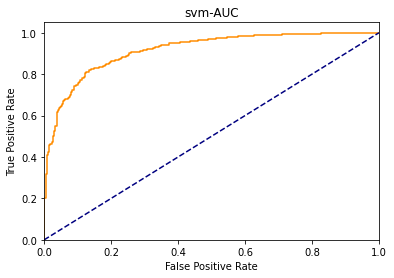

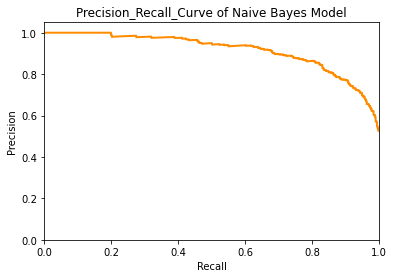

In [3]:
# Test the function with 'svm'

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

AUC: 91.50% PRC: 91.59%


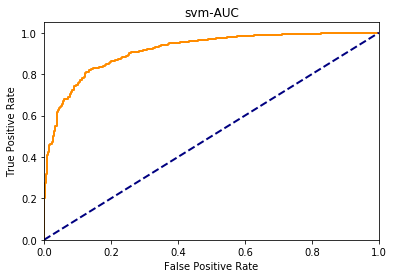

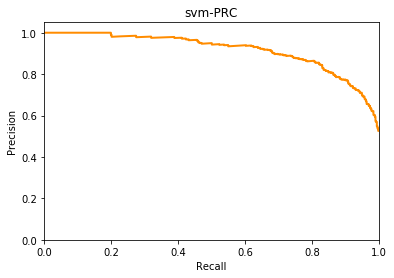

In [12]:
# Test the function with 'svm'

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       509
           1       0.78      0.83      0.80       491

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

AUC: 88.87% PCR: 89.49%


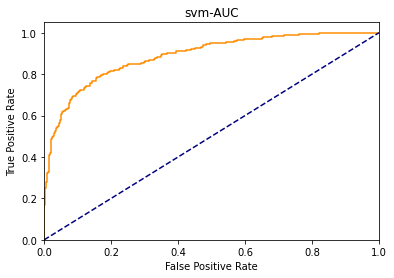

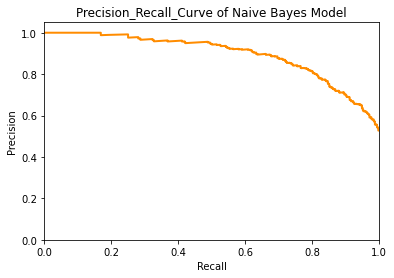

In [4]:
# Test the function with 'nb' 

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       509
           1       0.78      0.83      0.80       491

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

AUC: 88.87% PRC: 89.49%


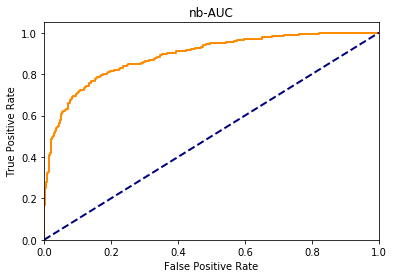

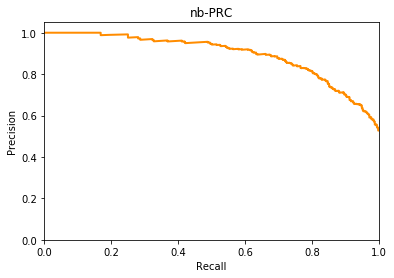

In [13]:
# Test the function with 'nb' 

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.2,0.5,0.8]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [5]:
# Define grade search function

def search_para(docs, y):
    
    # Add your code here
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC())
                   ])

    parameters = {'tfidf__min_df':[1,2,5],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.2,0.5,0.8],
    }

    metric =  "f1_macro"

    gs_clf = GridSearchCV\
    (text_clf, param_grid=parameters, \
     scoring=metric, cv=5)

    gs_clf = gs_clf.fit(docs, y)
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,\
                                 gs_clf.best_params_[param_name]))


In [6]:
search_para(train["text"], train["label"])

clf__C:	0.2
tfidf__min_df:	2
tfidf__stop_words:	None


In [15]:
search_para(train["text"], train["label"])

clf__C:	0.2
tfidf__min_df:	2
tfidf__stop_words:	None


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

AUC: 92.42% PCR: 92.30%


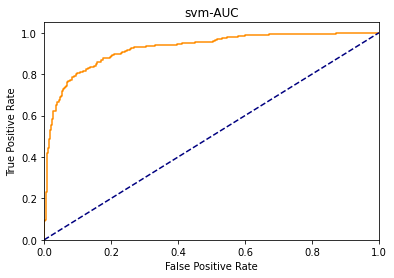

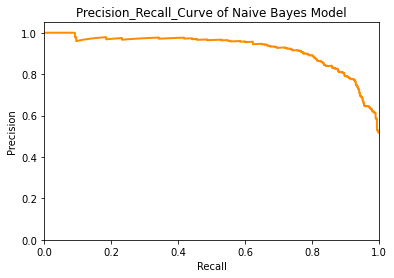

In [7]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.2)

# Please answer the questions
# AUC improved about 1%, PCE improved about 0.7%
# 1. none stopwords, usually when stopwords are applied, the results will be better, maybe there are meaningful ones.
# 2. min_df is 2 means some high-specific vocabularies which only appear once are removed, which can improve results.
# 3. C is set to 0.2, given that the strength of the regularization is inversely proportional to C, 
# which means we need to higher the fault tolerance of the dividing boundary, which also help to prevent overfitting.

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

AUC: 92.42% PRC: 92.30%


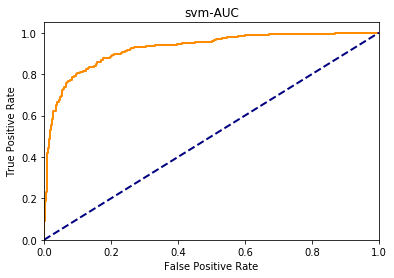

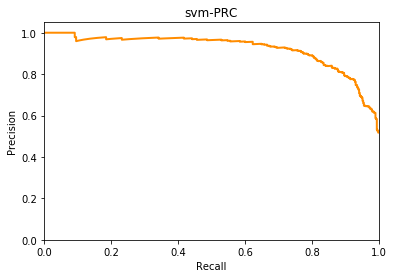

In [16]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.2)

# Please answer the questions


## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and then `model_type='nb'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [8]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):
    
    # add your code here
    
    svm_auc = []
    nb_auc = []
    x = []
    for i in range(500,len(train["text"])+1,500):
        auc_s, prc_s = create_model(train_docs[0:i], train_y[0:i], test_docs, test_y, \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
        svm_auc.append(auc_s)
        auc_s1, prc_s = create_model(train_docs[0:i], train_y[0:i], test["text"], test["label"], \
          model_type='nb', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
        nb_auc.append(auc_s1)
        x.append(i)
    plt.plot(x,svm_auc,color="darkorange",label="SVM")
    plt.plot(x,nb_auc,color="navy",label="NB")
    plt.xlabel("sample size")
    plt.ylabel("AUC")
    plt.legend(loc="best")
    plt.show()


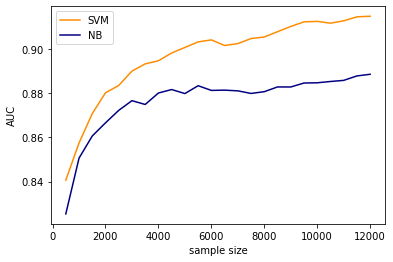

In [9]:
# Test the function

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions
# 1. The number of samples is positively correlated with AUC, 
# and the number of samples from 0 to 6000 has a more significant impact on AUC
# 2. It depends on how much accuary we need, if 90% is okay, i would pick 6000,
# but if thee higher the better, i would still pick 12000 which is all of the samples
# 3. svm perform better all the time that nb, much better when feeding over 2000 samples

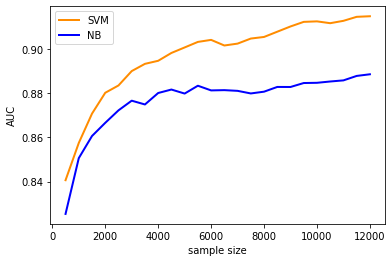

In [18]:
# Test the function

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [10]:
 # add your code here
# Tried to tune thess sets of parameters, if the best choice is the default (the first value), then comment it.
# There is not so much to tune with TfidfVectorizer or SVM model with this sample.
# It could be time consuming if tuning too many parameters at the same time, I am using up to 4.
# The conclusion I got is setting max_df to 0.9 on the result I got on task2

In [11]:
def search_para_task4(docs, y):
    
    # Add your code here
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC())
                   ])

    parameters = {'tfidf__min_df':[1,2,3],
              'tfidf__max_df':[0.9,0.95,1.0],    
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.1,0.2,0.25,0.15],
#              'clf__tol': [1e-4,1e-5,1e-3,1e-2]
#              'clf__loss': ['squared_hinge','hinge'],
#              'clf__penalty': ['l2','l1']
#              'clf__fit_intercept': ['True','False']
    }

    metric =  "f1_macro"

    gs_clf = GridSearchCV\
    (text_clf, param_grid=parameters, \
     scoring=metric, cv=5)

    gs_clf = gs_clf.fit(docs, y)
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,\
                                 gs_clf.best_params_[param_name]))

In [12]:
search_para_task4(train["text"], train["label"]) 

clf__C:	0.2
tfidf__max_df:	0.9
tfidf__min_df:	2
tfidf__stop_words:	None
